In [1]:
import cv2
import tensorflow as tf
import numpy as np
import os
import random
import scipy.misc as misc
import json
%matplotlib inline

import matplotlib.pyplot as plt



/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
IMAGE_DIRECTORY = '/Users/xuehan.xiong/Google Drive/datasets/human_pose/images'
DIRECTORY = '/Users/xuehan.xiong/Google Drive/datasets/human_pose'
FILENAME = 'MPI_annotations.json'
RESIZE_DIM = 640

data = []
with open(os.path.join(DIRECTORY,FILENAME)) as data_file:
    data_this = json.load(data_file)
    data_this = data_this['root']
    data = data + data_this


In [3]:
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    if type(value) is np.ndarray or type(value) is list:
        return tf.train.Feature(float_list=tf.train.FloatList(value=value))
    else:
        return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))
    
# nop - number of people
def _concat_scale(scale,scale_others,nop):
    output = []
    if nop > 2:
        output = np.asarray([scale] + scale_others)
    elif nop == 2:
        output = np.asarray([scale,scale_others])
    else:
        output = scale
    return output

def _concat_objpos(objpos,objpos_others,nop):
    output = []
    objpos_array = np.asarray(objpos)
    if nop > 2:
        objpos_others_array = np.asarray(objpos_others)
        output = np.concatenate(([objpos_array],objpos_others_array),axis=0)
    elif nop == 2:
        objpos_others_array = np.asarray(objpos_others)
        output = np.concatenate(([objpos_array],[objpos_others_array]),axis=0)
    else:
        output = objpos_array
    return output

def _concat_joints(joints,joints_others,nop):
    joints_array = np.asarray(joints)
    output = joints_array
    if nop > 2:
        joints_others_array = np.asarray(joints_others)
        for i in xrange(joints_others_array.shape[0]):
            output = np.concatenate((output,joints_others_array[i]),axis=0)
    elif nop == 2:
        joints_others_array = np.asarray(joints_others)
        output = np.concatenate((output,joints_others_array),axis=0)
    return output

def _resize(image,centers,scales,joints):
    height,width = image.shape[:2]
    if (height <= RESIZE_DIM):
        return image,centers,scales,joints
    scale_factor = float(RESIZE_DIM) / float(height)
    resized_image = cv2.resize(image,(0,0),fx=scale_factor,fy=scale_factor)
    assert resized_image.shape[0] == RESIZE_DIM
    resized_centers = scale_factor * centers
    resized_scales = scales * scale_factor
    resized_joints = joints
    resized_joints[:,:2] *= scale_factor
    return resized_image,resized_centers,resized_scales,resized_joints
    

[[ 494.  360.]
 [ 195.  377.]
 [ 312.  315.]
 [ 399.  342.]
 [ 710.  400.]
 [ 786.  390.]
 [ 835.  343.]]
0.0
(16, 3)
(16, 3)
(16, 3)
(16, 3)
(15, 3)
(16, 3)
(16, 3)


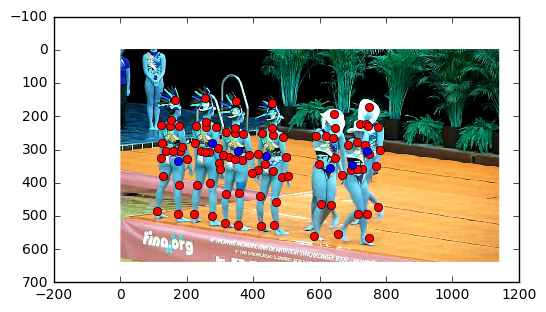

In [5]:
        
index = 820
image_path = os.path.join(IMAGE_DIRECTORY,data[index]['img_paths'])
image = cv2.imread(image_path);
height,width = image.shape[:2]

nop = int(data[index]['numOtherPeople'])+1
objpos = data[index]['objpos']
objpos_others = data[index]['objpos_other']
centers = _concat_objpos(objpos,objpos_others,nop)
print centers
print data[index]['isValidation']
scale = data[index]['scale_provided']
scale_others = data[index]['scale_provided_other']
scales = _concat_scale(scale,scale_others,nop)

joint_others = data[index]['joint_others']
joint_self = data[index]['joint_self']
joints = _concat_joints(joint_self,joint_others,nop)

joints_others_array = np.asarray(joint_others)
for i in xrange(joints_others_array.shape[0]):
    print np.asarray(joints_others_array[i]).shape

print np.asarray(joint_self).shape

resized_image,resized_centers,resized_scales,resized_joints = _resize(image,centers,scales,joints)

plt.imshow(resized_image)
vis_index = resized_joints[:,2] == 1.0
plt.plot(resized_joints[vis_index,0],resized_joints[vis_index,1],'ro')
plt.plot(resized_centers[:,0],resized_centers[:,1],'bo')
plt.show()



In [6]:
def _preprocess(data,image,index):
    nop = int(data[index]['numOtherPeople'])+1
    objpos = data[index]['objpos']
    objpos_others = data[index]['objpos_other']
    centers = _concat_objpos(objpos,objpos_others,nop)

    scale = data[index]['scale_provided']
    scale_others = data[index]['scale_provided_other']
    scales = _concat_scale(scale,scale_others,nop)

    joint_others = data[index]['joint_others']
    joint_self = data[index]['joint_self']
    joints = _concat_joints(joint_self,joint_others,nop)

    height,width = image.shape[:2]
    mask = np.logical_or(joints[:,0] <= 0.0, joints[:,1] <= 0)
    mask = np.logical_or(joints[:,0] >= float(width), mask)
    mask = np.logical_or(joints[:,1] >= float(height), mask)
    joints[mask,2] = -1.0

    resized_image,resized_centers,resized_scales,resized_joints = _resize(image,centers,scales,joints)
    return nop,resized_image,resized_centers,resized_scales,resized_joints

def convert_to(data, is_train, name):
    num_examples = len(data)
    print('Total of %d images' % num_examples)
    output = os.path.join(DIRECTORY, name + '.tfrecords')
    print('Writing', output)
    writer = tf.python_io.TFRecordWriter(output)
    random_order = np.random.permutation(num_examples).tolist()
    count = 0
    for index in random_order:
        # read image
        if data[index]['isValidation'] != 0 and is_train:
            continue
        if data[index]['isValidation'] == 0 and (not is_train):
            continue
        image_path = os.path.join(IMAGE_DIRECTORY,data[index]['img_paths'])
        image = cv2.imread(image_path)
        nop,resized_image,resized_centers,resized_scales,resized_joints = _preprocess(data,image,index)
        image_raw = resized_image.tostring()
        height = resized_image.shape[0]
        width = resized_image.shape[1]
        assert resized_image.shape[2] == 3
        if np.mod(resized_joints.shape[0],16) != 0:
            print 'skip image %d that has %d joints' % (index,resized_joints.shape[0])
            continue
        # create an example in TF's format
        example = tf.train.Example(features=tf.train.Features(feature={
        'height':     _int64_feature(height),
        'width':      _int64_feature(width),
        'num_people': _int64_feature(nop),
        'scales':     _float_feature(resized_scales),
        'centers':    _float_feature(resized_centers.flatten()),
        'joints':     _float_feature(resized_joints.flatten()),
        'image_raw':  _bytes_feature(image_raw)}))
        writer.write(example.SerializeToString())
        count = count + 1
    writer.close()
    print 'Total of %d image written' % count


In [7]:
convert_to(data,True,'MPI_train')




Total of 28883 images
('Writing', '/Users/xuehan.xiong/Google Drive/datasets/human_pose/MPI_train.tfrecords')
skip image 5224 that has 110 joints
skip image 18402 that has 29 joints
skip image 20837 that has 31 joints
skip image 18519 that has 78 joints
skip image 10327 that has 109 joints
skip image 24786 that has 79 joints
skip image 27526 that has 30 joints
skip image 28344 that has 142 joints
skip image 18583 that has 63 joints
skip image 2636 that has 46 joints
skip image 19108 that has 47 joints
skip image 16354 that has 63 joints
skip image 14976 that has 94 joints
skip image 17235 that has 110 joints
skip image 9638 that has 63 joints
skip image 855 that has 62 joints
skip image 25345 that has 46 joints
skip image 12525 that has 46 joints
skip image 22130 that has 31 joints
skip image 15450 that has 31 joints
skip image 28547 that has 77 joints
skip image 12133 that has 78 joints
skip image 3312 that has 93 joints
skip image 25344 that has 46 joints
skip image 127 that has 125 